In [66]:
import os, glob, json

import re, math

import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.discrete.discrete_model as sm_dm
# from statsmodels.formula.api import logit, probit, poisson, ols

from IPython.display import display
pd.options.display.max_columns = 1000
# pd.options.display.precision = 1
# pd.options.display.float_format = lambda x: '%.1f' % x

import seaborn as sns
sns.set(rc={"figure.figsize" : (8, 6)})
sns.set(font_scale = 1.0) 
sns.set(style="white", color_codes=True)
sns.set_context('notebook', font_scale=1.0, rc={'line.linewidth': 2.5, "figure.figsize" : (8, 4)})

import requests
import psycopg2
from netrc import netrc
user, acct, passwd = netrc().authenticators("harris")

# from dist_tools import *

## Load the racial/ethnic composition of _actual_ districts, from the Census.

In [2]:
columns = ["Male VAP", "Female VAP", "Male BVAP", "Female BVAP", "Male HVAP", "Female HVAP", "State", "CD"]

api_endpt = "https://api.census.gov/data/{}/acs/acs5?for=congressional+district:*&get=" + \
            "B05003_008E,B05003_019E,B05003B_008E,B05003B_019E,B05003I_008E,B05003I_019E"

j113 = requests.get(api_endpt.format(2012)).json()
j114 = requests.get(api_endpt.format(2014)).json()
j115 = requests.get(api_endpt.format(2016)).json()

df113 = pd.DataFrame(columns = columns, data = j113[1:]).astype(int)
df113["Session"] = 113

df114 = pd.DataFrame(columns = columns, data = j114[1:]).astype(int)
df114["Session"] = 114

df115 = pd.DataFrame(columns = columns, data = j115[1:]).astype(int)
df115["Session"] = 115

In [3]:
vaps = pd.concat([df113, df114, df115])

vaps.loc[vaps.CD == 0, "CD"] = 1
vaps.loc[vaps.CD == 98, "CD"] = 1
vaps = vaps[(vaps.State != 11) & (vaps.State < 57)]

vaps["VAP"]     = vaps["Male VAP"] + vaps["Female VAP"]
vaps["BVAP"]    = vaps["Male BVAP"] + vaps["Female BVAP"]
vaps["HVAP"]    = vaps["Male HVAP"] + vaps["Female HVAP"]

vaps["black_vap_frac"]          = vaps["BVAP"] / vaps["VAP"]
vaps["hispanic_vap_frac"]       = vaps["HVAP"] / vaps["VAP"]
vaps["total_minority_vap_frac"] = vaps["black_vap_frac"] + vaps["hispanic_vap_frac"]
vaps["max_minority_vap_frac"]   = vaps[["black_vap_frac", "hispanic_vap_frac"]].max(axis = 1)

vaps = vaps[["State", "CD", "Session",
             "black_vap_frac", "hispanic_vap_frac", 
             "total_minority_vap_frac", "max_minority_vap_frac"]]

In [4]:
true_minority_shares = vaps.loc[(vaps.Session == 114) & ~vaps.State.isin([11, 72])].copy()

In [5]:
# minority_shares = """
# select 
#   usps, cd, seats, sum(b01001_001e) population, 
#   1.*sum(b01001b_001e)/sum(b01001_001e) black_frac,
#   1.*sum(b01001i_001e)/sum(b01001_001e) hispanic_frac,
#   1.*GREATEST(sum(b01001b_001e), 1.*sum(b01001i_001e))/sum(b01001_001e) max_minority_frac,
#   1.*sum(black_vap)/sum(total_vap) black_vap_frac,
#   1.*sum(hispanic_vap)/sum(total_vap) hispanic_vap_frac,
#   1.*(sum(hispanic_vap)+sum(black_vap))/sum(total_vap) total_minority_vap_frac,
#   1.*GREATEST(sum(black_vap), 1.*sum(hispanic_vap))/sum(total_vap) max_minority_vap_frac
# from census_tracts_2015 tr 
# join cd on cd.state = tr.state and ST_Covers(cd.geom, tr.centroid) 
# join states st on st.fips = cd.state 
# join acssf5y2015 acs on
#   acs.state = tr.state AND
#   acs.county = tr.county AND
#   acs.tract = tr.tract
# where 
#   tr.state not in (11, 72) and 
#   sessn = 114
# group by usps, cd, seats order by usps, cd;
# """

# true_minority_shares = pd.read_sql(minority_shares, 
#                                    con = psycopg2.connect(database = "census", user = user, password = passwd,
#                                                           host = "saxon.harris.uchicago.edu", port = 5432))

In [6]:
tract_race = pd.read_sql("""SELECT
                              s.usps, rn.rn, 
                              d.state, d.county cid, d.tract,
                              b01001_001e pop, b01001a_001e white,
                              b01001b_001e black, b01001i_001e hispanic,
                              total_vap, black_vap, hispanic_vap
                            FROM census_tracts_2015 AS g
                            JOIN states AS s ON
                              g.state = s.fips
                            JOIN acssf5y2015 AS d ON
                              d.state  = g.state  AND
                              d.county = g.county AND
                              d.tract  = g.tract
                            JOIN (SELECT state, county, tract,
                                         row_number() over (PARTITION BY state ORDER BY county, tract NULLS LAST) - 1 as rn
                                  FROM census_tracts_2015) rn ON
                              g.state  = rn.state  AND
                              g.county = rn.county AND
                              g.tract  = rn.tract
                            ORDER BY d.state, d.county, d.tract;
                            """,
                            con = psycopg2.connect(database = "census", user = user, password = passwd,
                                                   host = "saxon.harris.uchicago.edu", port = 5432),
                            index_col = ["usps", "rn"])

In [7]:
# I do not simulate single-district states, so they must be added explicitly.
single_seats = """select usps, seats, 
                         sum(b01001b_001e)/sum(b01001_001e) black_frac, 
                         sum(b01001i_001e)/sum(b01001_001e) hispanic_frac,
                         1.*sum(black_vap)/sum(total_vap) black_vap_frac, 
                         1.*sum(hispanic_vap)/sum(total_vap) hispanic_vap_frac 
                  from acssf5y2015 
                  join states on acssf5y2015.state = fips 
                  where seats = 1 and usps != 'DC' group by usps, seats;"""

single_simulated = pd.read_sql(single_seats, con = psycopg2.connect(database = "census", user = user, password = passwd,
                                                                    host = "saxon.harris.uchicago.edu", port = 5432))

data = []
for f in sorted(glob.glob("/media/jsaxon/brobdingnag/data/s3/res/??/power/s*/c*/*csv")):
    
    usps = re.sub(r".*/res/(..)/.*", r"\1", f).upper()
    df = pd.read_csv(f, names = ["rn", "region"], header = None, index_col = "rn")
    df = df.join(tract_race.loc[usps])
    df = df.groupby("region").sum()
    df["black_vap_frac"]    = df["black_vap"]    / df["total_vap"]
    df["hispanic_vap_frac"] = df["hispanic_vap"] / df["total_vap"]
    df["black_frac"]        = df["black"]        / df["pop"]
    df["hispanic_frac"]     = df["hispanic"]     / df["pop"]
    
    target = df["pop"].sum() / df.shape[0]
    df["deviation"] = (df["pop"]/target - 1).abs()
    if df["deviation"].max() > 0.02: continue
    
    for di, row in df.iterrows():        
        data.append([usps, df.shape[0],
                     row["black_frac"], row["hispanic_frac"], 
                     row["black_vap_frac"], row["hispanic_vap_frac"]])

# Append multi-district states to the single-district ones.
simulated = single_simulated.append(pd.DataFrame(data, columns = ["usps", "seats", 
                                                                  "black_frac", "hispanic_frac", 
                                                                  "black_vap_frac", "hispanic_vap_frac"]))
simulated.reset_index(drop = True, inplace = True)

# Constructed variables -- not used for paper.
simulated["max_minority_frac"] = simulated[["black_frac", "hispanic_frac"]].max(axis = 1)
simulated["max_minority_vap_frac"] = simulated[["black_vap_frac", "hispanic_vap_frac"]].max(axis = 1)
simulated["total_minority_frac"] = simulated[["black_frac", "hispanic_frac"]].sum(axis = 1)
simulated["total_minority_vap_frac"] = simulated[["black_vap_frac", "hispanic_vap_frac"]].sum(axis = 1)

# How much is each individual seat/plan worth?
nsim = simulated.groupby("usps").count()[["seats"]]
nsim.rename(columns = {"seats" : "simulated"}, inplace = True)
nsim[["seats"]] = simulated.groupby("usps").mean()[["seats"]]
nsim["weight"] = nsim["seats"] / nsim["simulated"]
nsim.reset_index(inplace = True)

# Merge the weights back on.
simulated = simulated[["usps", "seats", 
                       "black_frac", "hispanic_frac", 
                       "black_vap_frac", "hispanic_vap_frac", 
                       "max_minority_frac", "max_minority_vap_frac",
                       "total_minority_frac", "total_minority_vap_frac"]].merge(nsim[['usps', 'weight']], on = "usps")

### Turning this off for now, to quickly add the VAP rates.

In [8]:
# single_seats = "select usps, seats, sum(b01001b_001e)/sum(b01001_001e) black_frac, sum(b01001i_001e)/sum(b01001_001e) hispanic_frac from acssf5y2015 join states on acssf5y2015.state = fips where seats = 1 and usps != 'DC' group by usps, seats;"

# single_simulated = pd.read_sql(single_seats, con = psycopg2.connect(database = "census", user = user, password = passwd,
#                                                                     host = "saxon.harris.uchicago.edu", port = 5432))

# data = []
# for f in sorted(glob.glob("../cluscious/res/json/*_power_*json")):
    
#     with open(f) as fi: j = json.load(fi)
#     if j["PopulationDeviation"] > 0.02: continue
    
#     usps  = j["USPS"]
#     seats = j["Seats"]
#     for d in j["Districts"]:
        
#         data.append([usps, seats, d["Populations"]["BlackFrac"], 
#                                   d["Populations"]["HispanicFrac"]])
        
# simulated = single_simulated.append(pd.DataFrame(data, columns = ["usps", "seats", "black_frac", "hispanic_frac"]))
# simulated.reset_index(drop = True, inplace = True)

# simulated["max_minority_frac"] = simulated[["black_frac", "hispanic_frac"]].max(axis = 1)

# nsim = simulated.groupby("usps").count()[["seats"]]
# nsim.rename(columns = {"seats" : "simulated"}, inplace = True)
# nsim[["seats"]] = simulated.groupby("usps").mean()[["seats"]]
# nsim["weight"] = nsim["seats"]/nsim["simulated"]
# nsim.reset_index(inplace = True)

# simulated = simulated[["usps", "seats", "black_frac", "hispanic_frac", "max_minority_frac"]].merge(nsim[['usps', 'weight']], on = "usps")

In [85]:
def plot(xvar, xtitle, f, seats, legend = False):

    true_minority_shares.sort_values(by = xvar, inplace = True)
    true_minority_shares.reset_index(drop = True, inplace = True)
    true_minority_shares["cum_seats"] = list(435 - true_minority_shares.index.array)

    simulated.sort_values(by = xvar, ascending = False, inplace = True)
    simulated.reset_index(drop = True, inplace = True)
    simulated["cum_seats"] = simulated[["weight"]].cumsum()

    ax = simulated.plot(x = xvar, y = "cum_seats", color = "red", linewidth = 2,
                        label = "Power Diagrams", legend = legend)

    true_minority_shares.plot(x = xvar, y = "cum_seats", color = "k", linewidth = 2, linestyle = "dotted",
                              ax = ax, label = "114th Congress")
    
    
    frac = true_minority_shares[true_minority_shares["cum_seats"] > seats][xvar].max()
    ax.plot([0.1, frac], [seats, seats], linewidth = 1.5, linestyle = "dotted", color = "k")
    print(xtitle, frac)

    ax.set_xlabel(xtitle)
    ax.set_xlim(0.15, 0.6)

    ax.set_ylabel("Seats")
    ax.set_yticks([0, 25, 50, 75, 100, 125])
    
    # The plot y limits stretch between "corners" of the simulated seats.
    mini = simulated[simulated[xvar] < 0.60]["cum_seats"].min()
    maxi = simulated[simulated[xvar] > 0.15]["cum_seats"].max()
    ax.set_ylim(0, 110)

    sns.despine()
    
    plt.legend(loc='upper right')
    ax.legend().set_visible(legend)

    ax.get_figure().savefig(f, bbox_inches='tight', pad_inches=0.3)
    

In [86]:
# plot("max_minority_frac", "Maximum Minority Share (Black or Hispanic)", "minority_representation.pdf", 86, True)
# plot("black_frac", "Black Share", "black_representation.pdf", 46)
# plot("hispanic_frac", "Hispanic Share", "hispanic_representation.pdf", 40)

Black Share (VAP) 0.2903432611988706
Hispanic Share (VAP) 0.405591366979044


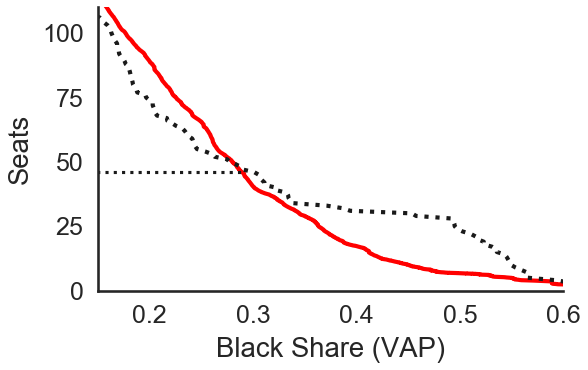

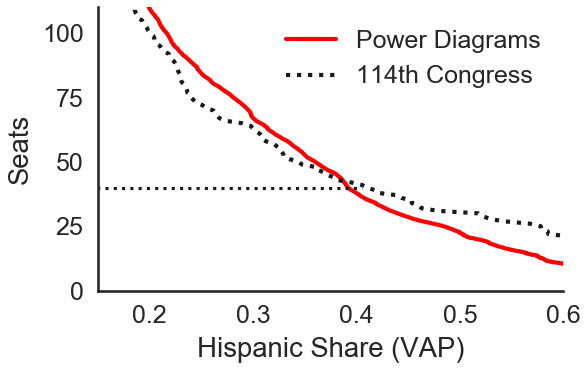

In [87]:
sns.set_context('notebook', font_scale=1.2, rc={'line.linewidth': 2.5, "figure.figsize" : (4, 2.5)})

# plot("max_minority_vap_frac", "Maximum Minority Share (Black or Hispanic, VAP)", "minority_vap_representation.pdf", 89, True)
plot("black_vap_frac",    "Black Share (VAP)",    "paper_figs/black_vap_representation.pdf", 46)
plot("hispanic_vap_frac", "Hispanic Share (VAP)", "paper_figs/hispanic_vap_representation.pdf", 40, True)

## The Probit Model

### Load the actual outcomes.

Note that I am rejecting here the delegates -- from DC, VI, MP, and PR -- all of whom are minorities.

In [88]:
! cat min_rep/sources.txt

http://history.house.gov/Exhibitions-and-Publications/BAIC/Historical-Data/Black-American-Representatives-and-Senators-by-Congress/
http://history.house.gov/Exhibitions-and-Publications/HAIC/Historical-Data/Hispanic-American-Representatives,-Senators,-Delegates,-and-Resident-Commissioners-by-Congress/

https://pressgallery.house.gov/member-data/demographics/african-americans
https://pressgallery.house.gov/member-data/demographics/hispanic-americans

Discrepancies (in pressgallery but not history -- added):
Trent Franks R-AZ-8
John Garamendi D-CA-3
Brian Mast R-FL-18

https://api.census.gov/data/2012/acs5?for=congressional+district:*&get=NAME,B05003_008E,B05003_019E,B05003B_008E,B05003B_019E,B05003I_008E,B05003I_019E
https://api.census.gov/data/2014/acs5?for=congressional+district:*&get=NAME,B05003_008E,B05003_019E,B05003B_008E,B05003B_019E,B05003I_008E,B05003I_019E

See also: http://www.pewresearch.org/fact-tank/2017/01/24/115th-congress-sets-new-high-for-racial-ethnic-diversity/



In [93]:
min_rep = pd.read_excel("min_rep/minority_representatives.xlsx")

st = pd.read_sql("select usps, fips from states;",
                 con = psycopg2.connect(database = "census", user = user, password = passwd,
                                        host = "saxon.harris.uchicago.edu", port = 5432))

min_rep = pd.merge(min_rep, st, left_on = "State", right_on = "usps")
min_rep = min_rep[(min_rep.Delegate == 0) & ((min_rep.Session == 113) | (min_rep.Session == 114) | (min_rep.Session == 115))]
min_rep = min_rep[["Session", "fips", "CD", "Ethnicity", "Name", "Delegate"]].rename(columns = {"fips" : "State"})
min_rep.sort_values(by = ["Session", "State", "CD"], inplace = True)
min_rep.reset_index(drop = True, inplace = True)

# min_rep

In [95]:
min_rep_merge = vaps.merge(min_rep, on = ["Session", "State", "CD"], how = "outer")
min_rep_merge["BRep"] = (min_rep_merge["Ethnicity"] == "B").astype(int)
min_rep_merge["HRep"] = (min_rep_merge["Ethnicity"] == "H").astype(int)
min_rep_merge["MRep"] = (~min_rep_merge["Ethnicity"].isnull()).astype(int)
min_rep_merge["const"] = 1
min_rep_merge.sort_values(by = ["State", "CD", "Session"], inplace = True)

#### Keeping only one of Chaka Fattah or Dwight Evans, and Xavier Becerra or Jimmy Gomez, since they were all elected from the same districts.

In [96]:
min_rep_merge.drop_duplicates(["Session", "State", "CD"], inplace = True, keep = "first")
min_rep_merge[(min_rep_merge.MRep == 1) & (min_rep_merge.duplicated(["State", "CD", "Session"], keep = False))].sort_values(by = ["Session", "State", "CD"])

,State,CD,Session,black_vap_frac,hispanic_vap_frac,total_minority_vap_frac,max_minority_vap_frac,Ethnicity,Name,Delegate,BRep,HRep,MRep,const


In [97]:
min_rep_merge.groupby("Session")[["BRep", "HRep"]].sum()

,BRep,HRep
Session,,
113,41,33
114,44,34
115,46,40


In [98]:
def run_probit(session, frac, truth, sim_var, label, file):
    
    session_slice = min_rep_merge[min_rep_merge.Session == session].copy(deep = True)
    session_slice.reset_index(drop = True, inplace = True)
    # print(session_slice.shape)
    # display(session_slice)

    probit = sm_dm.Probit(session_slice[truth], session_slice[[frac, "const"]]).fit()
    # session_slice["FV"] = probit.fittedvalues
    # session_slice["Probit"] = norm.sf(-probit.fittedvalues)
    
    session_slice["Probit"] = norm.sf(- (session_slice[frac] * probit.params[frac] + probit.params.const))

    ax = session_slice.sort_values(by = frac).plot(kind = "scatter", x = frac, y = truth, c = 'b', label = "Representatives")
    session_slice.sort_values(by = frac).plot(x = frac, y = "Probit", c = 'r', kind = "scatter", label = "Probit Model", ax = ax)

    ax.set_ylabel(label + " Representative")
    ax.set_xlabel(label + " Fraction")

    probit_seats = session_slice.drop_duplicates(["State", "CD"]).Probit.sum()
    simulated_seats = (simulated["weight"] * norm.sf(- (simulated[sim_var] * probit.params[frac] + probit.params.const))).sum()

    print(- probit.params.const / probit.params[frac], probit_seats, simulated_seats)
    

Optimization terminated successfully.
         Current function value: 0.140741
         Iterations 7
0.35173447278039055 45.956649875160934 41.896872394633526
Optimization terminated successfully.
         Current function value: 0.172508
         Iterations 7
0.5198787162117372 39.95561026597257 37.03536330271475
Optimization terminated successfully.
         Current function value: 0.266521
         Iterations 7
0.5045446593444521 85.46375159669557 80.03212621568723
Optimization terminated successfully.
         Current function value: 0.272315
         Iterations 7
0.41613598317491346 85.19473572729689 78.36709541211926


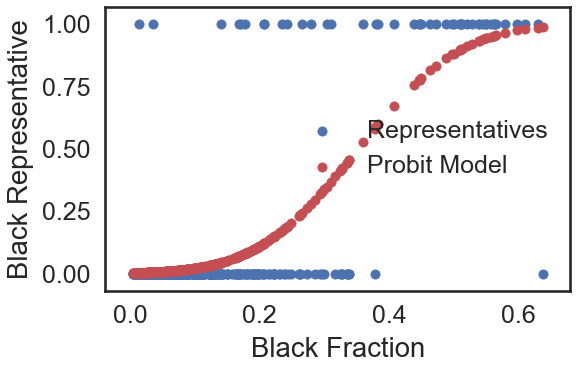

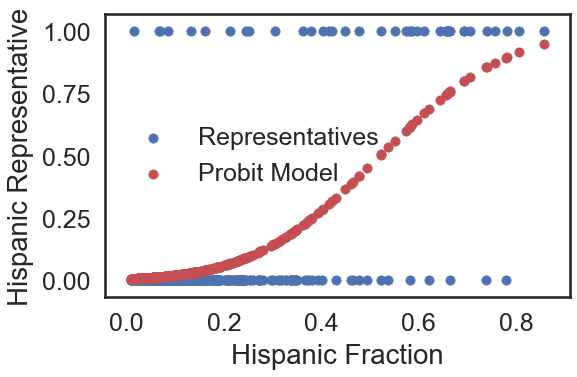

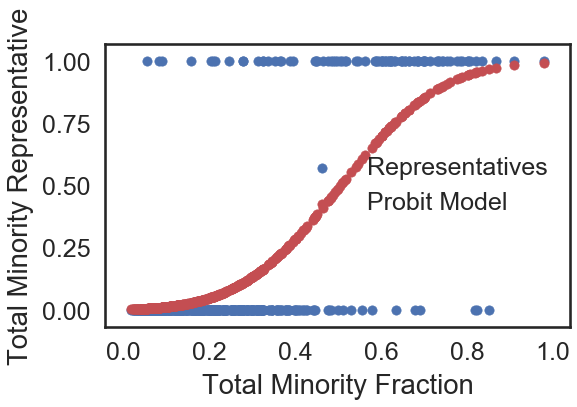

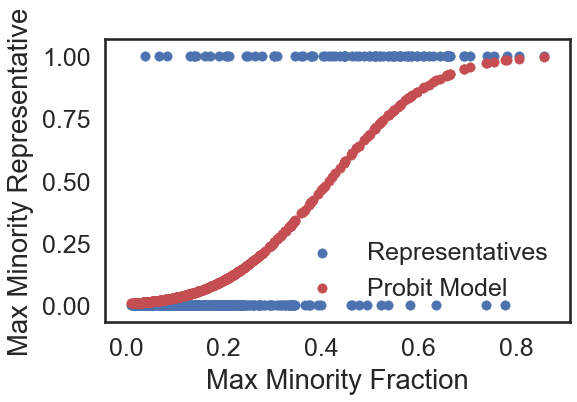

In [100]:
run_probit(115, "black_vap_frac",          "BRep", "black_vap_frac",           "Black",          "probit_black")
run_probit(115, "hispanic_vap_frac",       "HRep", "hispanic_vap_frac",        "Hispanic",       "probit_hispanic")
run_probit(115, "total_minority_vap_frac", "MRep", "total_minority_vap_frac",  "Total Minority", "probit_total_minority")
run_probit(115, "max_minority_vap_frac",   "MRep", "max_minority_vap_frac",    "Max Minority",   "probit_max_minority")

In [101]:
41.9/46.0, 37/40.0

(0.9108695652173913, 0.925)

In [105]:
min_rep_merge[(min_rep_merge.Session == 115) & (min_rep_merge.black_vap_frac >=  0.2)].shape[0], \
min_rep_merge[(min_rep_merge.Session == 115) & (min_rep_merge.black_vap_frac >=  0.3)].shape[0]

(74, 45)